In [1]:
import json
import nltk
import RAKE
import re
import operator 
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import math
import enchant
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from gensim import corpora, models 
import string
import math
import enchant
import gensim
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer


emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]   
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
#remove emoji in string

def remove_emoji(data):
    """
    去除表情
    :param data:
    :return:
    """
    if not data:
        return data
    if not isinstance(data, str):
        return data
    try:
    # UCS-4
        patt = re.compile(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])')
    except re.error:
    # UCS-2
        patt = re.compile(u'([\u2600-\u27BF])|([\uD83C][\uDF00-\uDFFF])|([\uD83D][\uDC00-\uDE4F])|([\uD83D][\uDE80-\uDEFF])')
    return patt.sub('', data)
    
def tokenize(s):
    return tokens_re.findall(s)

def WordCheck(word):#拼写检查  
    d = enchant.Dict("en_GB")  
    if d.check(word):
        return(word)

###Extract entity names
def extract_entity_names(t):
    entity_names = []

    if hasattr(t, 'label') and t.label:
        if t.label() == 'NE':
            entity_names.append(' '.join([child[0] for child in t]))
        else:
            for child in t:
                entity_names.extend(extract_entity_names(child))

    return entity_names

def get_entities(sent):
    sentences = nltk.sent_tokenize(sent)
    tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in sentences]
    tagged_sentences = [nltk.pos_tag(sentence) for sentence in tokenized_sentences]
    chunked_sentences = nltk.ne_chunk_sents(tagged_sentences, binary=True)
    entities = []
    for tree in chunked_sentences:
        entities.extend(extract_entity_names(tree))
    return(entities)

punctuation = list(string.punctuation)
punctuation.append('…')
punctuation.append('—')
punctuation.append('・')
stop = stopwords.words('english') + punctuation + ['rt', 'via']

from nltk.corpus import names
people_names = ([name.lower() for name in names.words("male.txt")]+[name.lower() for name in names.words("female.txt")])

def preprocessRAKE(s, lowercase=False):
#    d=enchant.Dict("en_GB") 
#    tokenizer = RegexpTokenizer(r'\w+')
    Entities=get_entities(s)
#    en_stop = get_stop_words('en')
    #remove emoji
    s = remove_emoji(s)
    #remove urls
    s = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', s)
    #Remove non-letters      
#    letters_only = re.sub("[^a-zA-Z]", " ", s) 
#    tokens = tokenize(letters_only)
    tokens = tokenize(s)
    tokens = [token.lower() for token in tokens 
              if token not in Entities] 
    tokens = [token for token in tokens 
              if token not in people_names]     
    tokens = [token for token in tokens
              if not token.startswith(('#','@'))]
#    tokens = [token for token in tokens 
#              if token not in stop]
#    tokens = [token for token in tokens 
#              if len(token)>=3 and token not in en_stop]  
#    tokens = [token for token in tokens 
#              if d.check(token)]    
    return tokens

def preprocessLDA(s, lowercase=False):
    d=enchant.Dict("en_GB") 
    tokenizer = RegexpTokenizer(r'\w+')
    Entities=get_entities(s)
    en_stop = get_stop_words('en')
    #remove emoji
    s = remove_emoji(s)
    #remove urls
    s = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', s)
    #Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", s) 
    tokens = tokenize(letters_only)
    tokens = [token for token in tokens
              if not token.startswith(('#','@'))]
    tokens = [token for token in tokens 
              if token not in stop]
    tokens = [token for token in tokens 
              if len(token)>=3 and len(token)<16 and token not in en_stop]
    tokens = [token.lower() for token in tokens 
              if token not in Entities]    
    return tokens

def getlda(doc_set,ward_name,num_topics=10):
    texts = []
    for i in doc_set:
        tokens=preprocessLDA(i, lowercase=False)
        tokens=tokenize(i)
        tokens=[token
                for token in tokens
                if token not in ward_name.lower()]
        texts.append(tokens)

# turn our tokenized documents into a id <-> term dictionary
    dictionary = corpora.Dictionary(texts)
    
# convert tokenized documents into a document-term matrix
    corpus = [dictionary.doc2bow(text) for text in texts]

# generate LDA model
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word = dictionary,alpha='auto', iterations=1000,passes=20)
    return(ldamodel)

#check
#lda_model=getlda(doc_set)
#print(lda_model.print_topics(num_topics=3, num_words=3))

def gettopics(doc_set,ward_name,num_topics=10):
    LDA=getlda(doc_set,ward_name,num_topics)
    topics=result.show_topics(formatted=False)
    topics_matrix=[]
    for topic in topics:
        topics_matrix.append(topic[1])
        topics_matrix=np.array(topics_matrix)
        topic_words = topics_matrix[:,:,0]
        TOPICS=[]
        for i in range(len(topic_words)):
            topici=' '.join([str(word) for word in topic_words[i]])
            print(type(topici))
            TOPICS.append(topici)
    return TOPICS

In [2]:
ward_users30 = []
with open('ward_users30.txt') as f:
    for line in f:
        ward_users30.append(json.loads(line))
ward_users30=ward_users30[0]
print(ward_users30[2])
print(len(ward_users30))
user_tweets = []
with open('user_tweets.txt') as f:
    for line in f:
        user_tweets.append(json.loads(line))
user_tweets=user_tweets[0]
print(user_tweets[2])
print(len(user_tweets))
normal_users = []
with open('normal_users.txt') as f:
    for line in f:
        normal_users.append(json.loads(line))
normal_users=normal_users[0]
print(len(normal_users))
user_wards = []
with open('user_wards.txt') as f:
    for line in f:
        user_wards.append(json.loads(line))
user_wards=user_wards[0]
print(user_wards[2])
print(len(user_wards))
tweets=[]
with open('DataSet.txt') as f:
    for line in f:
        tweets.append(json.loads(line))
tweets=tweets[0]
print(tweets[2])
print(len(tweets))
#tenfold30=[]
#with open('10fold_keywords.txt') as f:
#    for line in f:
#        tenfold30.append(json.loads(line))
#tenfold30=tenfold30[0]
#print(tenfold30[2])
#print(len(tenfold30))


{'Test': {}, 'freq_visitor': ['334151730', '2951653264', '1370880571', '22914886', '6385722', '246547192', '131484244', '310881064', '528381341', '1416294271', '2275298746', '242249139', '15979756', '48049477', '380814299', '281188372', '3005657973', '22045240', '23641442', '67858143', '8753592', '4485551', '2204572020', '96082478', '15790798', '1306161914', '20305536', '3119556363', '18580103', '2454324347', '2176351266', '7089552', '1621840039', '27940731', '3353688604', '145304575', '16981246', '46444574', '354790263', '182361249'], 'Ward': 'Riverside, Southwark', 'Training': {}}
23
{'Tweets': ['What a #dissertationmess i made! #dissertationdiaries #goldsmithslibrary @ Goldsmiths,… https://t.co/47zXyVso8z', 'What a #dissertationmess i made! #dissertationdiaries #goldsmithslibrary @ Goldsmiths,… https://t.co/47zXyVso8z', 'Fly my abstract bird fly... #dissertationlife #dissertationdistraction #origami @ Goldsmiths,… https://t.co/HsU5ESM7LB', "Found it! Princess Caroline's sunken bath.

In [3]:
tweets_reg_users=[]
for tweet in tweets:
    if tweet["Regular"]=="yes":
        tweets_reg_users.append(tweet)
print(len(tweets_reg_users))

78650


print("Mobility patterns of user (ID: 1115365597):", "\n","\n", user_wards[7], "\n")
print(Counter(user_wards[7]["Wards"]),"\n")
print(Counter(user_wards[7]["Wards"]).most_common(3))

W=[]
for w in ward_users30:
    W.append(w["Ward"])
print(W)

In [4]:
import random
def train_test_split(data_users):
    random.shuffle(data_users)
    N=len(data_users)
    ntest=int(0.1*N)
    test_users=[]
    training_users=[]
    for i in range(10):
        TEST=data_users[i*ntest:(i+1)*ntest]
        TRAINING=[user for user in data_users if user not in TEST]
        test_users.append(TEST)
        training_users.append(TRAINING)
    return training_users, test_users
#wards having by more than 30 regular visitors
def mobility_patterns(user, num_top):
    for item in user_wards:
        if item["User"]==user:
            wards=item["Wards"]
            c=Counter(wards)
            mps_all=c.most_common()
            mps_top=c.most_common(num_top)
            mps=[mp[0] for mp in mps_all]
            mp_top=[mp[0] for mp in mps_top]
    return mps, mp_top

def ward_names_removed(mps):
    ward_removal=' '.join(mp.lower() for mp in mps)
    return(ward_removal)

def get_tweets_test_user(user,mps):
    d = enchant.Dict("en_GB") 
    for tweet in user_tweets:
        if tweet["User"]==user:
            texts=tweet["Tweets"]
    texts=list(set(texts))
    user_texts=[]
    for t in range(len(texts)):
        words=preprocessRAKE(texts[t])
        text=' '.join([str(w) for w in words if d.check(w) and w not in ward_names_removed(mps)])
        user_texts.append(text)
    return user_texts

def get_tweets_ward(ward,users):
    training_text=[]
    d = enchant.Dict("en_GB")
    training_texts=[tweet["Text"] 
                    for tweet in tweets_reg_users
                    if tweet["Ward"]==ward and tweet["User"] in users]
    texts=list(set(training_texts))
    for t in range(len(texts)):
        words=preprocessRAKE(texts[t])
        text=' '.join([str(w) for w in words if d.check(w) and w not in str(ward).lower()])
        training_text.append(text)
    return training_text


def get_tweets_ward_LDA(ward,users):
    training_text=[]
    d = enchant.Dict("en_GB")
    training_texts=[tweet["Text"] 
                    for tweet in tweets_reg_users
                    if tweet["Ward"]==ward and tweet["User"] in users]
    texts=list(set(training_texts))
    for t in range(len(texts)):
        words=preprocessLDA(texts[t])
        text=' '.join([str(w) for w in words if d.check(w) and w not in stop and w not in str(ward).lower() and w not in str("greater london united kingdom uk")])
        training_text.append(text)
    return training_text

def getrake(texts):
    keywords=[]
    Rake = RAKE.Rake("smartstoplist.txt")
    for text in texts:
        rake_results=Rake.run(text)
        for keyword in rake_results:
            if keyword[1]>1:
                if str(keyword[0]) not in punctuation:
                    k=re.sub('…', '', str(keyword[0]))
                    k=re.sub('—', '', str(keyword[0]))
                    k=re.sub('・', '', str(keyword[0]))
                    keywords.append(k)
    keywords=[ " ".join(re.findall("[a-zA-Z]+", k))
              for k in keywords
              if k!="greater london" and k!="united kingdom" and k!="london" and k!="uk"]    

    no2letters=[]
    for label in keywords:
        tokens=tokenize(str(label))
        a=[token 
           for token in tokens 
           if len(token)>2 and token not in str("greater london united kingdom uk")]
        a=' '.join(a)
        no2letters.append(a)

    C=Counter(no2letters).most_common()
    labels=[c[0] for c in C if len(c[0])>2 and c[0]!='']    
    labels=labels[0:100]
    return labels

def get_keywords_user_rake(users,num_words,mps):
    test_user_texts=get_tweets_test_user(test_user,mps)
    test_user_keywords=getrake(test_user_texts)[0:num_words]
    return test_user_keywords

def get_other_wards(user,ward):
    for item in user_wards:
        ws=item["Wards"]
        other_wards=[]
        if item["User"]==user:
            other_wards=list(ws)
            other_wards.remove(ward)
    return other_wards

def tweets_in_outside_ward(user,ward):
    wards_outside=get_other_wards(user,ward)
    d = enchant.Dict("en_GB") 
    in_ward=[tweet["Text"] 
             for tweet in tweets_reg_users
             if tweet["User"]==user and tweet["Ward"] in ward]
    tweets_inside=list(set(in_ward))
    tweets_inside_ward=[]
    for t in range(len(tweets_inside)):
        words=preprocessRAKE(tweets_inside[t])
        text=' '.join([str(w) for w in words if len(w)>2 and d.check(w) and w not in ward_names_removed(ward)])
        tweets_inside_ward.append(text)
    outside_ward=[tweet["Text"] 
             for tweet in tweets_reg_users
             if tweet["User"]==user and tweet["Ward"] in wards_outside]
    tweets_outside=list(set(outside_ward))
    tweets_outside_ward=[]
    for t in range(len(tweets_outside)):
        words=preprocessRAKE(tweets_outside[t])
        text=' '.join([str(w) for w in words if len(w)>2 and d.check(w) and w not in ward_names_removed(wards_outside)])
        tweets_outside_ward.append(text)
    return tweets_inside_ward, tweets_outside_ward 

def uniquetokens(terms) :
    uniqueWords = [] 
    for i in terms:
        if not i in uniqueWords:
            uniqueWords.append(i)
    return uniqueWords

def idf(Nt, N):
    a=dict((k, math.log(N/int(v))) for k, v in dict(Nt).items())   
    return(a)

def getidf(doc_set):
    Nt=Counter() 
    N=0
    for doc in doc_set:
        d = enchant.Dict("en_GB") 
        terms_only = tokenize(doc)
        terms_unique = uniquetokens(terms_only)  
        Nt.update(terms_unique)
        N=N+1
    IDF=idf(Nt,N)
    return IDF

#term frequency
def tf(terms,counts):
    a=dict((k, int(v)/float(len(terms))) for k, v in dict(counts).items())   
    return(a)

def gettfidf(user,ward,num_words):
    tweets_inside_ward, tweets_outside_ward=tweets_in_outside_ward(user,ward)
    inside_texts=' '.join(text for text in tweets_inside_ward)
    outside_texts=tweets_outside_ward
    doc_set=[inside_texts]
    for item in outside_texts:
        doc_set.append(item)  
    IDF=getidf(doc_set)

    new_doc_set=[inside_texts,' '.join(text for text in tweets_outside_ward)]
    tfidf_results=[]
    for doc in doc_set:
        d=enchant.Dict("en_GB") 
        # Count terms only once, equivalent to Document Frequency    terms_single = set(terms_all)
        terms_only = tokenize(doc)
        count_term=Counter(terms_only)
        TF=tf(terms_only,count_term)
        tfidf=dict((k,TF[k]*IDF[k]) for k,v in TF.items())
        rank=sorted(tfidf.items(), key=lambda d:d[1], reverse = True)
        if rank!="" :
            for item in rank[0:100]:
                tfidf_results.append(item[0])
           
    C=Counter(tfidf_results).most_common()
    labels=[ " ".join(re.findall("[a-zA-Z]+", c[0]))
            for c in C 
            if d.check(c[0]) and c[0] not in stop and c[0] not in str("greater london united kingdom uk")]  
    #d.check(c[0]) and
    kw_tfidf=[label 
              for label in labels 
              if label!='']
    kw_tfidf=kw_tfidf[0:num_words]
    return kw_tfidf


    

#keywords to keywords
dataset=ward_users30
aa=0
for i in range(len(dataset)):
    print(i)
    ward=dataset[i]["Ward"]
    print(ward)
    users=dataset[i]["freq_visitor"]
    training,test=train_test_split(users)
    tenfoldresult=[]
    for j in range(len(training)):
        training_users=training[j]
        training_texts=get_tweets_ward(ward,training_users)
        ward_keywords_rake=getrake(training_texts)
        ward_keywords_tfidf=' '.join(keyword_rake for keyword_rake in ward_keywords_rake)
        test_users=test[j]
        #mobility patterns for test users
#        rake_matching=[]
        num_kws=[1,5,10]
        results=dict()
        for test_user in test_users:
#            test_user_mps,test_user_mps_top=mobility_patterns(test_user, 5)
#            test_users_rake=get_keywords_user_rake(test_user,50,ward)
            tfidf_matching=[]
            test_users_keywords=gettfidf(test_user,ward,20)
            for num in num_kws:
    #            rake_matches=set(test_users_rake)&set(ward_keywords_rake)
    #            rake_num_matches=len(matches)
    #            rake_percent_matches=rake_num_matches/len(test_users_rake)
    #            rake_matching.append(rake_percent_matches)
                test_users_tfidf=test_users_keywords[0:num]
                tfidf_num_matches=0
                for keyword in test_users_tfidf:
                    if keyword in ward_keywords_tfidf:
                        tfidf_num_matches=tfidf_num_matches+1
                if len(test_users_tfidf)!=0:
                    tfidf_percent_matches=tfidf_num_matches/len(test_users_tfidf)
                else:
                    tfidf_percent_matches="no matches"
                tfidf_matching.append(tfidf_percent_matches)
            results[test_user]=tfidf_matching
        final_results = { k : v for k,v in results.items() if "no matches" not in v}
        afoldresult=[]
        for k,v in final_results.items():
            afoldresult.append(v)
        afoldresult=np.mean(np.array(afoldresult),axis=0)
        tenfoldresult.append(afoldresult.tolist())
    print(tenfoldresult)
    dataset[i]["10-fold"]=tenfoldresult

#        print("Rake:",rake_matching)
#            print("Tf-idf",tfidf_matching)
                

#    dataset[i]["Training"]["Users"]=train
#    dataset[i]["Test"]["Users"]=test
#    dataset[i]["Training"]["Tweets"]=training_texts



In [8]:
#keywords to LDA topics
dataset=ward_users30
aa=0
for i in list(range(0,7)):
    print(i)
    ward=dataset[i]["Ward"]
    print(ward)
    users=dataset[i]["freq_visitor"]
    training,test=train_test_split(users)
    tenfoldresult=[]
    for j in range(len(training)):
        print(j)
        training_users=training[j]
        training_texts=get_tweets_ward_LDA(ward,training_users)
        result=getlda(training_texts,ward,num_topics=5)
        topics=result.show_topics(formatted=False,num_words=20)
        topics_matrix=[]
        for topic in topics:
            topics_matrix.append(topic[1])
        topics_matrix=np.array(topics_matrix)
        ward_topic_words = topics_matrix[:,:,0]
        W=[]
        for topic_words in ward_topic_words:
            for w in topic_words:
                W.append(w)
        W=set(W)
        test_users=test[j]
        #mobility patterns for test users
        num_kws=[1,5,10]
        results=dict()
        for test_user in test_users:
            tfidf_matching=[]
            test_users_keywords=gettfidf(test_user,ward,50)
            for num in num_kws:
    #            rake_matches=set(test_users_rake)&set(ward_keywords_rake)
    #            rake_num_matches=len(matches)
    #            rake_percent_matches=rake_num_matches/len(test_users_rake)
    #            rake_matching.append(rake_percent_matches)
                test_users_tfidf=test_users_keywords[0:num]
                tfidf_num_matches=0
                for keyword in test_users_tfidf:
                    if keyword in W:
                        tfidf_num_matches=tfidf_num_matches+1
                if len(test_users_tfidf)!=0:
                    tfidf_percent_matches=tfidf_num_matches/len(test_users_tfidf)
                else:
                    tfidf_percent_matches="no matches"
                tfidf_matching.append(tfidf_percent_matches)
            results[test_user]=tfidf_matching
        final_results = { k : v for k,v in results.items() if "no matches" not in v}
        afoldresult=[]
        for k,v in final_results.items():
            afoldresult.append(v)
        afoldresult=np.mean(np.array(afoldresult),axis=0)
        tenfoldresult.append(afoldresult.tolist())
    print(tenfoldresult)
    dataset[i]["10-fold_topics"]=tenfoldresult


7
St. James's, Westminster
0
1
2
3
4
5
6
7
8
9
[[0.12871287128712872, 0.22211221122112193, 0.23374980355178382], [0.12121212121212122, 0.22441077441077426, 0.23874859708193039], [0.15841584158415842, 0.21171617161716152, 0.22528288543140038], [0.18, 0.23866666666666655, 0.2619365079365079], [0.19, 0.3031666666666666, 0.30877380952380945], [0.1782178217821782, 0.24422442244224413, 0.2564827911362565], [0.2376237623762376, 0.28613861386138595, 0.3063059877416313], [0.19801980198019803, 0.26006600660065987, 0.2638535282099638], [0.21, 0.2521666666666666, 0.28318253968253965], [0.2, 0.2301666666666665, 0.2621349206349206]]


In [9]:
for i in range(len(dataset)):
    print(dataset[i]["10-fold_topics"])

[[0.5, 0.55, 0.575], [0.25, 0.3, 0.2916666666666667], [0.25, 0.275, 0.29642857142857143], [0.25, 0.3833333333333333, 0.4458333333333333], [0.25, 0.175, 0.175], [0.25, 0.35, 0.35], [0.25, 0.2, 0.2], [0.75, 0.6000000000000001, 0.5], [0.5, 0.4833333333333333, 0.4833333333333333], [0.0, 0.20000000000000004, 0.17777777777777778]]
[[0.18181818181818182, 0.2545454545454545, 0.2701298701298701], [0.2727272727272727, 0.4727272727272727, 0.4997474747474747], [0.0, 0.018181818181818184, 0.07272727272727272], [0.5454545454545454, 0.38181818181818183, 0.39999999999999997], [0.18181818181818182, 0.34090909090909094, 0.348989898989899], [0.09090909090909091, 0.2545454545454546, 0.3272727272727272], [0.45454545454545453, 0.3772727272727273, 0.4029220779220779], [0.18181818181818182, 0.2727272727272727, 0.3090909090909091], [0.2727272727272727, 0.32272727272727275, 0.3325757575757576], [0.18181818181818182, 0.36363636363636365, 0.38282828282828274]]
[[0.75, 0.475, 0.44166666666666665], [0.75, 0.525, 0.

In [12]:
avg_results=[]
Wnames=[]
tenfold30=dataset
for i in range(len(tenfold30)):
    avg_results.append(dict())
    avg=np.mean(np.array(tenfold30[i]["10-fold_topics"]),axis=0).tolist()
    Wnames.append(ward_users30[i]["Ward"])
    avg_results[i]["Ward"]=ward_users30[i]["Ward"]
#    avg_results[i]["# visitors"]=len(ward_users30[i]["freq_visitor"])
    avg_results[i]["1 keyword"]=avg[0]
    avg_results[i]["5 keywords"]=avg[1]
    avg_results[i]["10 keywords"]=avg[2]
    
from pandas import Series, DataFrame
import pandas as pd    

DataFrame(avg_results,columns=["1 keyword","5 keywords","10 keywords"],index=Wnames)  
DF=DataFrame(avg_results,columns=["1 keyword","5 keywords","10 keywords"],index=Wnames)  
results=np.array(DF.loc[:,["1 keyword","5 keywords","10 keywords"]])
results=np.mean(results,axis=0)
print(results)


[ 0.26224387  0.30721932  0.31346319]


In [31]:
dataset=ward_users30
wards_topics= list()
for i in [1,2]:
    wards_topics.append(dict())
    print(i)
    ward=dataset[i]["Ward"]
    print(ward)
    training_users=dataset[i]["freq_visitor"]
    training_texts=get_tweets_ward_LDA(ward,training_users)
    result=getlda(training_texts,ward,num_topics=15)
    results=result.print_topics(num_topics=15,num_words=20)
    for topic in range(len(results)):
        topici= 'Topic {}: {}'.format(topic, results[topic])
        print(topici,"\n")
#    topics=result.show_topics(formatted=False,num_words=20)
#    topics_matrix=[]
#    for topic in topics:
#        topics_matrix.append(topic[1])
#    topics_matrix=np.array(topics_matrix)
#    ward_topic_words = topics_matrix[:,:,0]
#    W=[]
#    for word in ward_topic_words:
#        for w in word:
#            W.append(w)
#    text=' '.join([str(w) for w in W])
#    wards_topics[i]['Ward']=ward
#    wards_topics[i]['Text']=text
#print(wards_topics)

1
Bishop's, Lambeth
Topic 0: (0, '0.057*day + 0.024*summer + 0.016*party + 0.016*beautiful + 0.015*good + 0.012*time + 0.011*lovely + 0.010*travel + 0.008*every + 0.008*kids + 0.008*making + 0.008*despite + 0.008*food + 0.008*happy + 0.008*long + 0.008*way + 0.008*fun + 0.008*drag + 0.008*bad + 0.008*artist') 

Topic 1: (1, '0.081*bridge + 0.026*home + 0.017*amp + 0.013*back + 0.013*got + 0.013*like + 0.013*jubilee + 0.013*bridges + 0.011*last + 0.009*photo + 0.009*director + 0.009*golden + 0.009*quick + 0.009*shadows + 0.009*look + 0.009*goodnight + 0.009*family + 0.009*express + 0.009*church + 0.008*welcome') 

Topic 2: (2, '0.075*royal + 0.065*festival + 0.046*hall + 0.026*expires + 0.026*till + 0.021*centre + 0.020*friends + 0.020*adventure + 0.013*dessert + 0.013*family + 0.010*foodie + 0.010*anti + 0.010*fucking + 0.010*elements + 0.009*one + 0.007*boring + 0.007*apology + 0.007*good + 0.007*watching + 0.007*get') 

Topic 3: (3, '0.043*chocolate + 0.026*banana + 0.018*dark + 0.01



wards_topics= list()
for i in range(len(dataset[0:1])):
    wards_topics.append(dict())
    words=[]
    for j in range(len(dataset[i]['Training']['Topics'])):
        words.append(tokenize(dataset[i]['Training']['Topics'][j])[3:])
    W=[]
    for word in words:
        for w in word:
            W.append(w)
    d = enchant.Dict("en_GB")
    text=' '.join([str(w) for w in W])
#if d.check(w)    
    wards_topics[i]['Ward']=dataset[i]['Ward']
    wards_topics[i]['Text']=text
print(wards_topics[0])


In [24]:
print(wards_topics[0:6])

[{'Text': 'thank hatch months brands circuit actually change fan watching congressman equality pick kills volatile model march apple launch luncheon cant track vehicle carrier reading set sail week amp really offer another hopefully upgraded excited note headed client top film years source bridge tower amp security passport stay invested games stack display blues mine twilight kind furry presume winter straight mile home coming magpies three wait time fans world get thanks ting mad rings quality appreciated arsenal mother nearly weed chucked wash airport car world proper fire shame line potential score showing day least batting recent weeks raw involved era losing west gate airways feel arrived please collecting good opening like new holiday physically basically without pulse lying dope boo sleep bus corner stop world free duty humidity best talk waiting scattered clouds thank time let singer producer said suppose title airways lounge airlines source first galleries big virgin eye exec

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


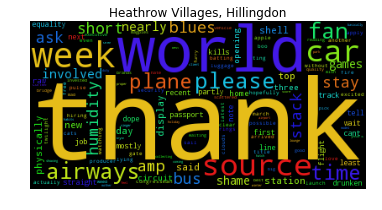

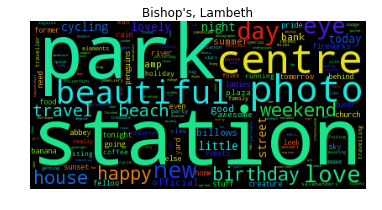

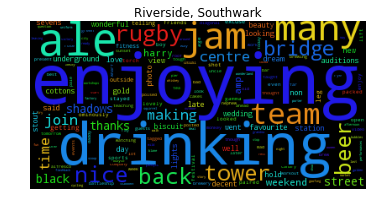

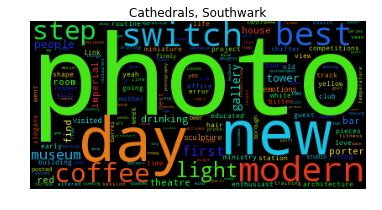

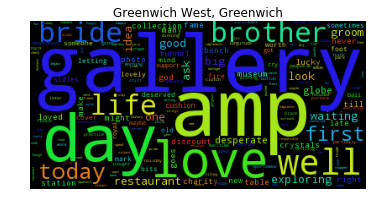

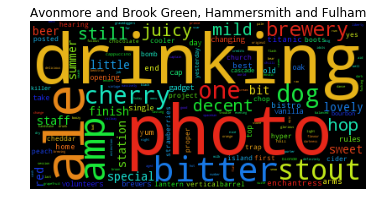

In [25]:
import wordcloud
from os import path
from wordcloud import WordCloud

import matplotlib.pyplot as plt
%pylab inline

for i in range(len(wards_topics[0:6])):
    text=wards_topics[i]['Text']

# Generate a word cloud image
    wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
    
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(wards_topics[i]['Ward'])
    plt.show()

# take relative word frequencies into account, lower max_font_size
#wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(text)
#plt.figure()
#plt.imshow(wordcloud)
#plt.axis("off")
#plt.show()

# The pil way (if you don't have matplotlib)

#image = wordcloud.to_image()
#image.show()

In [65]:
import json
with open('10fold_topics.txt', 'w') as outfile:
    json.dump(dataset, outfile)

In [ ]:
#def gettfidf(texts):
#keywords=[]
#tfidf = TfidfVectorizer(stop_words='english',use_idf=True, tokenizer=preprocessRAKE, ngram_range=(1,3))
#for text in doc_set:
#tfidf_matrix = tfidf.fit_transform(doc_set) #fit the vectorizer to synopses
#feature_names = tfidf.get_feature_names()
#for k in range(tfidf_matrix.shape[0]):
#    terms=[]
#    print(k)
#    for col in tfidf_matrix.nonzero()[1]:
#        if tfidf_matrix[k, col]>0:
#            terms.append([feature_names[col],tfidf_matrix[k, col]])
#    print(terms)
    